---
### <center> Carga de Datos

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import kendalltau
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [158]:
# Carga y visualización parcial de Datos:
df_ori = pd.read_csv('datasets/generacin-histrica.csv')
df_ori.head(5)

,anio,mes,maquina,central,agente,agente_descripcion,region,pais,tipo_maquina,fuente_generacion,tecnologia,categoria_hidraulica,categoria_region,generacion_neta_MWh,indice_tiempo
0,2012,1,3ARRDI01,3ARR,QUIL3A3A,QUILMES - PLANTA TRES ARROYOS,BUENOS AIRES,Argentina,MOTOR DIESEL,Térmica,DI,NaN,Gba - Litoral - Buenos Aires,0.000,2012-01
1,2012,1,ACAJTG01,CAPE,CAPEX-QA,CAPEX S.A. AUTOGENERADOR,COMAHUE,Argentina,TURBO GAS,Térmica,CC,NaN,Comahue,21868.984,2012-01
2,2012,1,ACAJTG02,ACAJ,CAPEXSAG,C.T. AGUA DEL CAJON,COMAHUE,Argentina,TURBO GAS,Térmica,CC,NaN,Comahue,24144.517,2012-01
3,2012,1,ACAJTG03,ACAJ,CAPEXSAG,C.T. AGUA DEL CAJON,COMAHUE,Argentina,TURBO GAS,Térmica,CC,NaN,Comahue,24259.713,2012-01
4,2012,1,ACAJTG04,ACAJ,CAPEXSAG,C.T. AGUA DEL CAJON,COMAHUE,Argentina,TURBO GAS,Térmica,CC,NaN,Comahue,26832.135,2012-01


---
### <center> Preparación de Datos

In [159]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91543 entries, 0 to 91542
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anio                  91543 non-null  int64  
 1   mes                   91543 non-null  int64  
 2   maquina               91543 non-null  object 
 3   central               91543 non-null  object 
 4   agente                91543 non-null  object 
 5   agente_descripcion    91543 non-null  object 
 6   region                91543 non-null  object 
 7   pais                  91543 non-null  object 
 8   tipo_maquina          91543 non-null  object 
 9   fuente_generacion     91543 non-null  object 
 10  tecnologia            91543 non-null  object 
 11  categoria_hidraulica  9349 non-null   object 
 12  categoria_region      91543 non-null  object 
 13  generacion_neta_MWh   91543 non-null  float64
 14  indice_tiempo         91543 non-null  object 
dtypes: float64(1), int6

In [160]:
# Chequeo de registros duplicados:
df_ori.duplicated().value_counts()

False    91543
dtype: int64

Observamos que el DataFrame posee 91543 registros, y que cada columna posee la misma cantidad de objetos no nulos (ni *'Nan'* ni *'None'*) a excepción de *'categoria_hidraulica'*, aunque esta es una columna no significativa para nuestro análisis. Además, no existen registros duplicados.

In [161]:
# Eliminamos la columna 'categoria_hidraulica':
df_ori.drop(['categoria_hidraulica'], axis=1, inplace=True)

In [81]:
# Chequeo de países presentes:
df_ori['pais'].value_counts()

Argentina      91541
(en blanco)        1
Paraguay           1
Name: pais, dtype: int64

In [162]:
# Redefinimos el dataset, conservando sólamente los registros válidos para Argentina:
df_ori = df_ori[df_ori['pais'] == "Argentina"]
df_ori['pais'].value_counts()

Argentina    91541
Name: pais, dtype: int64

In [6]:
# Como hemos eliminado registros, reseteamos los índices del DataFrame:
df_ori.set_index((i for i in range(len(df_ori))), inplace=True)

In [163]:
# Información actualizada:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91541 entries, 0 to 91542
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anio                 91541 non-null  int64  
 1   mes                  91541 non-null  int64  
 2   maquina              91541 non-null  object 
 3   central              91541 non-null  object 
 4   agente               91541 non-null  object 
 5   agente_descripcion   91541 non-null  object 
 6   region               91541 non-null  object 
 7   pais                 91541 non-null  object 
 8   tipo_maquina         91541 non-null  object 
 9   fuente_generacion    91541 non-null  object 
 10  tecnologia           91541 non-null  object 
 11  categoria_region     91541 non-null  object 
 12  generacion_neta_MWh  91541 non-null  float64
 13  indice_tiempo        91541 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 10.5+ MB


El DataFrame consta de 91541 registros, sin inconsistencias, valores no nulos ni duplicados. Todos los registros son pertenecientes a la Argentina.

---
### <center> Análisis exploratorio de Datos

Al consultar las **'fuentes_generacion'**, observamos que existen varias clasificaciones para las tecnologías no renovables (Térmica, Hidráulica y Nuclear):

In [84]:
df_ori['fuente_generacion'].value_counts()

Térmica       78568
Renovable      6469
Hidráulica     6230
Nuclear         274
Name: fuente_generacion, dtype: int64

In [98]:
# Analizamos los Tipos de tecnología disponibles:
df_ori['tecnologia'].value_counts()

DI      53765
TG      13977
CC       6288
HR       5477
TV       4620
HID      3871
EOL      1250
SOL       813
BIOM      664
BIOG      443
NUC       274
MHID       99
Name: tecnologia, dtype: int64

Estas Tecnologías se corresponden con las siguientes descripciones:

**No Renovables:**

* DI: Diesel
* TG: Turbo Gas
* CC: Ciclos Combinados
* HID: Hidroeléctrica
* NUC: Nuclear


**Renovables:**

* HR: Resto Hidráulico
* TV: Turbo Vapor
* EOL: Eólica
* SOL: Solar
* BIOM: Biomasa
* BIOG: Biogas
* MHID: Microhidráulica

In [99]:
# Corroboramos esta clasificación, consultando aquellas consideradas 'Renovables':
df_ori[df_ori['fuente_generacion'] == "Renovable"]['tecnologia'].value_counts()

HR      3118
EOL     1250
SOL      813
BIOM     664
BIOG     443
MHID      99
TV        82
Name: tecnologia, dtype: int64

Como la columna **'fuente_generacion'** posee varias clasificaciones según el origen de las fuentes no renovables, agrupamos estas clasificaciones y agregamos una columna **'renovable'** con valores booleanos que indique claramente si la producción es renovable o no:

In [167]:
df_ori['tipo_maquina'].unique()

# Cambiar todas las filas donde tipo_maquina = 'HIDRAULICA <=50' por 'HIDRAULICA MENOR 50' por problemas de conversión
df_ori.loc[df_ori['tipo_maquina'] == 'HIDRAULICA <=50', 'tipo_maquina'] = 'HIDRAULICA MENOR 50'

# muestra las filas que contienen 
# print(df_ori[df_ori['tipo_maquina'].str.contains('HIDRAULICA <=50')])

In [123]:
# Nuestro estudio de interés son las filas relacionadas a fuente_generacion = Renovable
filas_sel = []

for i, fila in df_ori.iterrows():
    if df_ori['fuente_generacion'][i] == 'Renovable':
        filas_sel.append(fila)

# Convierte las filas seleccionadas en un nuevo DataFrame
df_renov = pd.DataFrame(filas_sel)
df_renov

,anio,mes,maquina,central,agente,agente_descripcion,region,pais,tipo_maquina,fuente_generacion,tecnologia,categoria_region,generacion_neta_MWh,indice_tiempo
20,2012,1,ARAUEO,ARAUEO,PEARAUCG,PARQUE EOLICO ARAUCO SAPEM,NOROESTE,Argentina,EOLICA,Renovable,EOL,Noa,844.759,2012-01
212,2012,1,DIADEO,DIADEO,HYCHICOG,HYCHICO P. EOLICO DIADEMA,PATAGONICA,Argentina,EOLICA,Renovable,EOL,Patagonia,2034.575,2012-01
483,2012,1,ISBATV01,ISBA,AZUCTETA,AZUCARERA JUAN M.TERAN SA,NOROESTE,Argentina,TURBO VAPOR,Renovable,BIOM,Noa,0.000,2012-01
653,2012,1,NECOEO,NECOEO,SEAENERG,SEA ENERGY PARQUE EOLICO,BUENOS AIRES,Argentina,EOLICA,Renovable,EOL,Gba - Litoral - Buenos Aires,18.659,2012-01
760,2012,1,PUPITV01,PUPI,APARPPNA,ALTO PARANA-PTO.PIRAY,NORESTE,Argentina,TURBO VAPOR,Renovable,BIOM,Nea,1828.022,2012-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91510,2020,2,ULN1FV,ULN1FV,PSULLU1G,PQUE SOLAR ULLUM 1,CUYO,Argentina,FOTOVOLTAICA,Renovable,SOL,Cuyo,5779.081,2020-02
91511,2020,2,ULN2FV,ULN2FV,PSULLU2G,PQUE SOLAR ULLUM 2,CUYO,Argentina,FOTOVOLTAICA,Renovable,SOL,Cuyo,5993.749,2020-02
91519,2020,2,VLO2EO,VLO2EO,GENNEIAG,GENNEIA S.A.EOLICOS,BUENOS AIRES,Argentina,EOLICA,Renovable,EOL,Gba - Litoral - Buenos Aires,1171.872,2020-02
91520,2020,2,VLONEO,VLONEO,PEVILLAG,P.EOLICO VILLALONGA,BUENOS AIRES,Argentina,EOLICA,Renovable,EOL,Gba - Litoral - Buenos Aires,18407.240,2020-02


In [155]:
# Generar nuevo dataframe con columnas de interés

df = df_renov.iloc[:,[0,1,8,10,12]]
df = df.rename(columns={'anio': 'anio',
                         'mes': 'mes',
                'tipo_maquina': 'tipo_maquina',
                  'tecnologia': 'tecnologia',
            'categoria_region':'categoria_region',
         'generacion_neta_MWh': 'generacion_neta_MWh'})

In [125]:
# Agrupo para calcular matriz de correlacion

renov_tecn = df['tecnologia'].unique()
renov_cant = df['tecnologia'].value_counts()
renov_ener = (df.groupby('tecnologia')['generacion_neta_MWh'].sum())/1000

renov_ener

tecnologia
BIOG     1101.890268
BIOM     2431.589956
EOL     11954.536689
HR      11389.862697
MHID        6.782197
SOL      1199.223047
TV          2.489377
Name: generacion_neta_MWh, dtype: float64

In [126]:
# Calculo el total general de los datos
renov_tecn_tot = 'TOT'
renov_cant_tot = len(df)
renov_ener_tot = (df['generacion_neta_MWh'].sum())/1000

# Agregar el total a la agrupacion a la ultima posicion
renov_tecn = np.append(renov_tecn, renov_tecn_tot)
renov_cant = np.append(renov_cant, renov_cant_tot)
renov_ener = np.append(renov_ener, renov_ener_tot)


In [127]:
#Agrupacion para calcular matriz de correlacion
data = {
    'tecnologia': renov_tecn,
      'cantidad': renov_cant,
       'energia': renov_ener,
         'total': renov_ener_tot 
}

data_agrupada = pd.DataFrame(data)
print(data_agrupada)


  tecnologia  cantidad       energia         total
0        EOL      3118   1101.890268  28086.374231
1       BIOM      1250   2431.589956  28086.374231
2       MHID       813  11954.536689  28086.374231
3        SOL       664  11389.862697  28086.374231
4       BIOG       443      6.782197  28086.374231
5         HR        99   1199.223047  28086.374231
6         TV        82      2.489377  28086.374231
7        TOT      6469  28086.374231  28086.374231


In [128]:
# Calculamos matriz de correlacion de todo el conjunto de datos
matriz_correlacion = data_agrupada[['cantidad', 'energia']].corr()

# Imprime la matriz de correlación
print("Matriz de Correlación:")
print(matriz_correlacion)


Matriz de Correlación:
          cantidad   energia
cantidad  1.000000  0.762308
energia   0.762308  1.000000


In [68]:
# Seleccionar las columnas de interés
columnas_relevantes = ['tecnologia', 'cantidad', 'energia', 'total']

# Crear un DataFrame vacío para almacenar los resultados de correlación
resultados_correlacion = []

# Obtener la lista única de tecnologías
tecnologias_unicas = data_agrupada['tecnologia'].unique()

# Calcular la matriz de correlación para cada combinación de tecnología y variables
for tecnologia in tecnologias_unicas:
    datos_tecnologia = data_agrupada[data_agrupada['tecnologia'] == tecnologia]
    correlacion = datos_tecnologia[['cantidad', 'energia', 'total']].corr()
    
    # Agregar información de tecnología a la matriz de correlación
    correlacion['Tecnologia'] = tecnologia
    resultados_correlacion.append(correlacion)

# Concatenar los resultados en un solo DataFrame
resultado_final = pd.concat(resultados_correlacion)

# Imprimir el DataFrame con la matriz de correlación
print(resultado_final)


          cantidad  energia  total Tecnologia
cantidad       NaN      NaN    NaN        EOL
energia        NaN      NaN    NaN        EOL
total          NaN      NaN    NaN        EOL
cantidad       NaN      NaN    NaN       BIOM
energia        NaN      NaN    NaN       BIOM
total          NaN      NaN    NaN       BIOM
cantidad       NaN      NaN    NaN       MHID
energia        NaN      NaN    NaN       MHID
total          NaN      NaN    NaN       MHID
cantidad       NaN      NaN    NaN        SOL
energia        NaN      NaN    NaN        SOL
total          NaN      NaN    NaN        SOL
cantidad       NaN      NaN    NaN       BIOG
energia        NaN      NaN    NaN       BIOG
total          NaN      NaN    NaN       BIOG
cantidad       NaN      NaN    NaN         HR
energia        NaN      NaN    NaN         HR
total          NaN      NaN    NaN         HR
cantidad       NaN      NaN    NaN         TV
energia        NaN      NaN    NaN         TV
total          NaN      NaN    NaN

In [129]:
# Resumen de los datos estadísticos de energía renovable por tipo de tecnologia.
# Cinco medidas descriptivas de los datos: el primer cuartil (Q1), la mediana (Q2), el tercer cuartil (Q3),
# el valor máximo, y el valor mínimo
data_agrupada.describe()


,cantidad,energia,total
count,8.000000,8.000000,8.000000
mean,1617.250000,7021.593558,28086.374231
std,2188.379815,9824.365544,0.000000
min,82.000000,2.489377,28086.374231
25%,357.000000,828.113250,28086.374231
50%,738.500000,1815.406502,28086.374231
75%,1717.000000,11531.031195,28086.374231
max,6469.000000,28086.374231,28086.374231


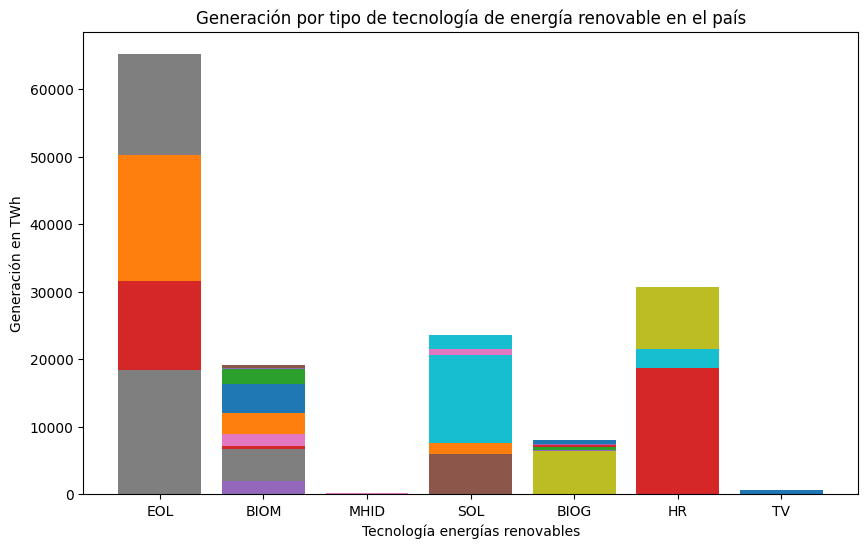

In [110]:
renov = df.groupby('tecnologia')['generacion_neta_MWh'].sum().reset_index()
#df.set_index((i for i in range(len(df))), inplace=True
renov = df.reset_index()
# Gráfico de Generación por tipo de energia renovable

plt.figure(figsize=(10, 6))
palette = sns.color_palette() 
plt.bar(renov['tecnologia'], renov['generacion_neta_MWh'], color=palette)
plt.xlabel('Tecnología energías renovables')
plt.ylabel('Generación en TWh')
plt.title('Generación por tipo de tecnología de energía renovable en el país')

plt.show()

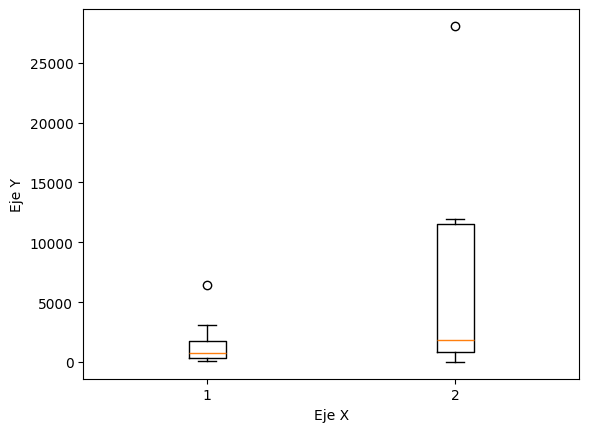

In [172]:
# Gráfico caja de bigotes
datos = [renov_cant, renov_ener]  

plt.boxplot(datos)
# Agrega etiquetas a los ejes
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Muestra el diagrama de caja
plt.show()


In [170]:
# Generamos un gráfico de barras apiladas:
anual_TWh.unstack().plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Generación eléctrica total anual según Renovabilidad")
plt.xlabel("Año")
plt.ylabel("Generación (TWh)")
plt.show()

NameError: name 'anual_TWh' is not defined

In [112]:
# Calcular el coeficiente de correlación de Pearson
correlacion_pearson = data_agrupada[['cantidad', 'energia', 'total']].corr(method='pearson')

# Calcular el coeficiente de correlación de Spearman
correlacion_spearman = data_agrupada[['cantidad', 'energia', 'total']].corr(method='spearman')

# Calcular el coeficiente de correlación de Kendall
correlacion_kendall = data_agrupada[['cantidad', 'energia', 'total']].corr(method='kendall')

print("Coeficiente de Correlación de Pearson:")
print(correlacion_pearson)

print("Coeficiente de Correlación de Spearman:")
print(correlacion_spearman)

print("Coeficiente de Correlación de Kendall:")
print(correlacion_kendall)


Coeficiente de Correlación de Pearson:
          cantidad   energia  total
cantidad  1.000000  0.851668    NaN
energia   0.851668  1.000000    NaN
total          NaN       NaN    NaN
Coeficiente de Correlación de Spearman:
          cantidad   energia  total
cantidad  1.000000  0.747899    NaN
energia   0.747899  1.000000    NaN
total          NaN       NaN    NaN
Coeficiente de Correlación de Kendall:
          cantidad  energia  total
cantidad       1.0      0.6    NaN
energia        0.6      1.0    NaN
total          NaN      NaN    1.0


In [130]:
corr_spearman = []

for i, fila in data_agrupada.iterrows():
    tecno_calc = data_agrupada[['cantidad', 'energia', 'total']].corr(method='spearman')
    corr_spearman.append(tecno_calc)

# Convierte las filas calculadas en un nuevo DataFrame
#df_spearman = pd.DataFrame(corr_spearman)
corr_spearman

[          cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000    NaN
 total          NaN       NaN    NaN,
           cantidad   energia  total
 cantidad  1.000000  0.642857    NaN
 energia   0.642857  1.000000   

In [114]:
# Agrupar los datos por 'tecnologia'
grupos = data_agrupada.groupby('tecnologia')

# Inicializar listas para almacenar las correlaciones de Spearman por tecnología
tecnologias = []
correlaciones_spearman = []

# Calcular la correlación de Spearman para cada grupo (tecnología)
for tecnologia, grupo in grupos:
    correlacion_spearman = stats.spearmanr(grupo['energia'], grupo['total'])
    
    tecnologias.append(tecnologia)
    correlaciones_spearman.append(correlacion_spearman.correlation)

# Crear un DataFrame con las correlaciones de Spearman
correlaciones_df = pd.DataFrame({'tecnologia': tecnologias, 'correlacion_spearman': correlaciones_spearman})

print(correlaciones_df)


  tecnologia  correlacion_spearman
0       BIOG                   NaN
1       BIOM                   NaN
2        EOL                   NaN
3         HR                   NaN
4       MHID                   NaN
5        SOL                   NaN
6        TOT                   NaN
7         TV                   NaN


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [131]:
# Agrupar los datos por 'tecnologia'
grupos = data_agrupada.groupby('tecnologia')

# Inicializar listas para almacenar las correlaciones de Pearson por tecnología
tecnologias = []
correlaciones_pearson = []

# Calcular la correlación de Pearson para cada grupo (tecnología)
for tecnologia, grupo in grupos:
    correlacion_pearson = grupo['cantidad'].corr(grupo['total'], method='pearson')
    
    tecnologias.append(tecnologia)
    correlaciones_pearson.append(correlacion_pearson)

# Crear un DataFrame con las correlaciones de Pearson
correlaciones_df = pd.DataFrame({'tecnologia': tecnologias, 'correlacion_pearson': correlaciones_pearson})

print(correlaciones_df)


  tecnologia  correlacion_pearson
0       BIOG                  NaN
1       BIOM                  NaN
2        EOL                  NaN
3         HR                  NaN
4       MHID                  NaN
5        SOL                  NaN
6        TOT                  NaN
7         TV                  NaN


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [116]:
# Agrupar los datos por 'tecnología'
grupos = data_agrupada.groupby('tecnologia')

# Inicializar listas para almacenar las correlaciones de Kendall por tecnología
tecnologias = []
correlaciones_kendall = []

# Calcular la correlación de Kendall para cada grupo (tecnología)
for tecnologia, grupo in grupos:
    correlacion_kendall, _ = kendalltau(grupo['cantidad'], grupo['total'])
    
    tecnologias.append(tecnologia)
    correlaciones_kendall.append(correlacion_kendall)

# Crear un DataFrame con las correlaciones de Kendall
correlaciones_df = pd.DataFrame({'tecnologia': tecnologias, 'correlacion_kendall': correlaciones_kendall})

print(correlaciones_df)


  tecnologia  correlacion_kendall
0       BIOG                  NaN
1       BIOM                  NaN
2        EOL                  NaN
3         HR                  NaN
4       MHID                  NaN
5        SOL                  NaN
6        TOT                  NaN
7         TV                  NaN


In [133]:
# 'X' variables predictoras (características) y 'y' variable objetivo.

# Divide los datos en conjuntos de entrenamiento y prueba (80% de entrenamiento y 20% de prueba)
X_train, X_test, y_train, y_test = train_test_split(df[['anio', 'mes', 'tipo_maquina', 'tecnologia']], df['generacion_neta_MWh'], test_size=0.2, random_state=42)

# X_train y y_train datos de entrenamiento, y X_test y y_test datos de prueba.


In [134]:
from sklearn.model_selection import train_test_split

# Supongamos que tienes un DataFrame llamado 'data' con las características (X) y las etiquetas (y)
X = data_agrupada[['cantidad', 'energia']]
y = data_agrupada['total']

# Dividir los datos en conjuntos de entrenamiento y prueba (por ejemplo, 80% entrenamiento y 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train y y_train son los datos de entrenamiento
# X_test y y_test son los datos de prueba


In [156]:
# Crear un modelo de regresión lineal
modelo = LinearRegression()

# Entrenar el modelo en los datos de entrenamiento
modelo.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = modelo.predict(X_test)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y_test, y_pred)

# Imprimir el valor de R^2
print("Coeficiente de determinación (R^2):", r2)


Coeficiente de determinación (R^2): 0.0
